<a href="https://colab.research.google.com/github/shiwangi27/googlecolab/blob/main/DALL_E_VAE_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/DALL-E.git

  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-kb7esq2v
  Running command git clone -q https://github.com/openai/DALL-E.git /tmp/pip-req-build-kb7esq2v
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 21.6MB 1.3MB/s 
     |████████████████████████████████| 143kB 57.0MB/s 
     |████████████████████████████████| 1.9MB 46.4MB/s 
     |████████████████████████████████| 747kB 43.3MB/s 
  Created wheel for DALL-E: filename=DALL_E-0.1-cp37-none-any.whl size=6000 sha256=b384cc4484d10060e9abc4a1daeaba094bb9680b306cf6973645f3ca898fe525
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbz7yyoe/wheels/e9/f5/e7/efa7ddb4c5899f6e6ffbbd112b8c7a030872274a5cba9ccf04
Successfully built DALL-E
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Fou

In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown


In [ ]:
target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [ ]:
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


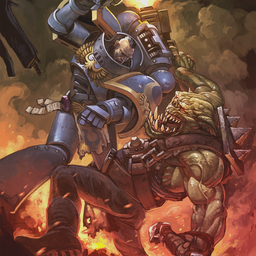

In [ ]:
x = preprocess(download_image('https://cdna.artstation.com/p/assets/images/images/001/069/354/large/gary-choo-gctest-superfinal1.jpg?1439378228'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

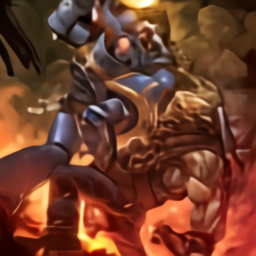

In [ ]:
import torch.nn.functional as F

z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

In [ ]:
x.size(), x_rec.size

(torch.Size([1, 3, 256, 256]), (256, 256))

In [ ]:
z_logits.size()

torch.Size([1, 8192, 32, 32])